# Autotalker Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 07.12.2022
- **Date of Last Modification:** 13.12.2022

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import itertools
import os
import random
import warnings
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Configure Paths and Create Directories

In [4]:
# Define paths
figure_path = "../figures"
model_artefacts_path = "../model_artefacts"
gp_data_folder_path = "../datasets/gp_data/" # gene program data
srt_data_folder_path = "../datasets/srt_data/" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_path, exist_ok=True)
os.makedirs(model_artefacts_path, exist_ok=True)
os.makedirs("mlruns", exist_ok=True)
os.makedirs(gp_data_folder_path, exist_ok=True)

### 1.3 Run Notebook Setup

In [5]:
# Define default matplotlib figure size
matplotlib.rcParams["figure.figsize"] = (5, 5)

In [6]:
# Ignore future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### 1.4 Define Parameters

In [7]:
# AnnData object
dataset = "squidpy_seqfish_mouse_organogenesis"
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"

# Others
random_seed = 42

### 1.5 Define Functions

In [11]:
def run_hyperparam_benchmarking(dataset,
                                hyperparam_option_dict,
                                n_iters,
                                experiment_name,
                                gp_mask="combined_priors",
                                save_model=False):
    
    experiment = mlflow.set_experiment(experiment_name)
        
    fig_benchmark_runs_dir = f"{figure_path}/{dataset}/benchmark_runs/"
    os.makedirs(fig_benchmark_runs_dir, exist_ok=True)
        
    # Retrieve gene program mask
    print("--- GENE PROGRAMS ---")
    print(f"Using '{gp_mask}' GP mask.")
    mlflow.log_param("gp_mask", gp_mask)
    if gp_mask == "combined_priors":
        nichenet_keep_target_ratio = 0.01
        omnipath_min_curation_effort = 0
        gp_filter_mode = None #"subset"
        combine_overlap_gps = False #True
        overlap_thresh_source_genes=0.9
        overlap_thresh_target_genes=0.9
        overlap_thresh_genes=0.9
        
        nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
            keep_target_ratio=nichenet_keep_target_ratio,
            load_from_disk=True,
            save_to_disk=True,
            file_path=nichenet_ligand_target_mx_file_path)
        omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
            min_curation_effort=omnipath_min_curation_effort,
            load_from_disk=False,
            save_to_disk=True,
            file_path=omnipath_lr_interactions_file_path)
        mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
            dir_path = "../datasets/gp_data/metabolite_enzyme_sensor_gps/",
            species="mouse",
            genes_uppercase=True)
        combined_gp_dict = dict(nichenet_gp_dict)
        combined_gp_dict.update(omnipath_gp_dict)
        combined_gp_dict.update(mebocost_gp_dict)

        # Filter and combine gene programs
        combined_new_gp_dict = filter_and_combine_gp_dict_gps(
            gp_dict=combined_gp_dict,
            gp_filter_mode=gp_filter_mode,
            combine_overlap_gps=combine_overlap_gps,
            overlap_thresh_source_genes=overlap_thresh_source_genes,
            overlap_thresh_target_genes=overlap_thresh_target_genes,
            overlap_thresh_genes=overlap_thresh_genes,
            verbose=True)

        mlflow.log_param("nichenet_keep_target_ratio", nichenet_keep_target_ratio)
        mlflow.log_param("omnipath_min_curation_effort", omnipath_min_curation_effort)
        mlflow.log_param("gp_filter_mode", gp_filter_mode)
        mlflow.log_param("combine_overlap_gps", combine_overlap_gps)
        mlflow.log_param("overlap_thresh_source_genes", overlap_thresh_source_genes)
        mlflow.log_param("overlap_thresh_target_genes", overlap_thresh_target_genes)
        mlflow.log_param("overlap_thresh_genes", overlap_thresh_genes)
        print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
        print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")
        print("")

    # Loop `n_iters` times through combination of hyperparams 
    iters = range(n_iters)
    hyperparams, hyperparam_values = zip(*hyperparam_option_dict.items())
    for hyperparam_comb in itertools.product(*hyperparam_values, iters):
        hyperparam_dict = {}
        for hyperparam, hyperparam_value in zip(hyperparams, hyperparam_comb):
            hyperparam_dict[hyperparam] = hyperparam_value
        
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        print("--- DATASET ---")
        print(f"Using dataset {dataset}.")
        mlflow.log_param("dataset", dataset)
        adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
        n_nodes = adata.layers["counts"].shape[0]
        n_genes = adata.layers["counts"].shape[1]
        print(f"Number of nodes (cells): {n_nodes}")
        print(f"Number of node features (genes): {n_genes}")
        mlflow.log_param("n_nodes", n_nodes)
        mlflow.log_param("n_genes", n_genes)

        if gp_mask == "fc":
            if hyperparam_dict["node_label_method"] == "self":
                n_output = len(adata.var)
                adata.varm[gp_targets_mask_key] = np.ones((hyperparam_dict["n_latent_fc_gps"], n_output))
            elif hyperparam_dict["node_label_method"] != "self":
                n_output = len(adata.var) * 2
                adata.varm[gp_targets_mask_key] = np.ones((hyperparam_dict["n_latent_fc_gps"], int(n_output / 2)))
                adata.varm[gp_sources_mask_key] = np.ones((hyperparam_dict["n_latent_fc_gps"], int(n_output / 2)))
            adata.uns[gp_names_key] = np.array([f"FC_GP_{i}" for i in range(hyperparam_dict["n_latent_fc_gps"])])
            n_hidden_encoder = int(hyperparam_dict["n_latent_fc_gps"]/2)
        elif gp_mask == "combined_priors":
            min_genes_per_gp = 1
            min_source_genes_per_gp = 0
            min_target_genes_per_gp = 0
            mlflow.log_param("min_genes_per_gp", min_genes_per_gp)
            mlflow.log_param("min_source_genes_per_gp", min_source_genes_per_gp)
            mlflow.log_param("min_target_genes_per_gp", min_target_genes_per_gp)            
            # Add the gene program dictionary as binary masks to the adata for model training
            add_gps_from_gp_dict_to_adata(
                gp_dict=combined_new_gp_dict,
                adata=adata,
                genes_uppercase=True,
                gp_targets_mask_key=gp_targets_mask_key,
                gp_sources_mask_key=gp_sources_mask_key,
                gp_names_key=gp_names_key,
                min_genes_per_gp=min_genes_per_gp,
                min_source_genes_per_gp=min_source_genes_per_gp,
                min_target_genes_per_gp=min_target_genes_per_gp,
                max_genes_per_gp=None,
                max_source_genes_per_gp=None,
                max_target_genes_per_gp=None)
            n_hidden_encoder = len(adata.uns[gp_names_key])
        # Summarize gene programs
        print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
        print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
        print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
        print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

        print("")
        print("--- SPATIAL CONNECTIVITY ---")
        # Compute spatial neighborhood
        sq.gr.spatial_neighbors(adata,
                                coord_type="generic",
                                spatial_key=spatial_key,
                                radius=hyperparam_dict["radius"])
                                #n_neighs=hyperparam_dict["n_neighs"])
        ax = sns.histplot(np.squeeze(np.asarray(adata.obsp['spatial_connectivities'].sum(axis=0))),
                          discrete=True)
        ax.set_title("Node Counts Per Number of Neighbors")
        ax.set_ylabel("Node Count")
        ax.set_xlabel("Number of Neighbors")
        fig = ax.figure
        fig.savefig(f"{fig_benchmark_runs_dir}/{current_timestamp}/node_counts_per_n_neighs.png")
        mlflow.log_figure(fig,
                          f"node_counts_per_n_neighs_{current_timestamp}.png")
        avg_edges_per_node = round(adata.obsp['spatial_connectivities'].sum(axis=0).mean(), 2)
        print(f"Average number of edges per node: {avg_edges_per_node}.")
        n_edges = int(sp.triu(adata.obsp['spatial_connectivities'], k=1).sum())
        print(f"Number of total edges: {n_edges}.")
        mlflow.log_param("n_neighbors", hyperparam_dict["n_neighs"])
        mlflow.log_param("n_edges", n_edges)

        # Initialize model
        print("")
        model = Autotalker(adata,
                           counts_key=counts_key,
                           adj_key=adj_key,
                           gp_names_key=gp_names_key,
                           active_gp_names_key=active_gp_names_key,
                           gp_targets_mask_key=gp_targets_mask_key,
                           gp_sources_mask_key=gp_sources_mask_key,
                           latent_key=latent_key,
                           include_edge_recon_loss=hyperparam_dict["include_edge_recon_loss"],
                           include_gene_expr_recon_loss=hyperparam_dict["include_gene_expr_recon_loss"],
                           gene_expr_recon_dist=hyperparam_dict["gene_expr_recon_dist"],
                           node_label_method=hyperparam_dict["node_label_method"],
                           active_gp_thresh_ratio=hyperparam_dict["active_gp_thresh_ratio"],
                           n_hidden_encoder=n_hidden_encoder,
                           conv_layer_encoder=hyperparam_dict["conv_layer_encoder"],
                           encoder_n_attention_heads=hyperparam_dict["encoder_n_attention_heads"],
                           n_addon_gps=hyperparam_dict["n_addon_gps"])

        # Train model
        print("")
        model.train(n_epochs=hyperparam_dict["n_epochs"],
                    n_epochs_all_gps=hyperparam_dict["n_epochs_all_gps"],
                    lr=hyperparam_dict["lr"],
                    lambda_edge_recon=hyperparam_dict["lambda_edge_recon"],
                    lambda_gene_expr_recon=hyperparam_dict["lambda_gene_expr_recon"],
                    lambda_group_lasso=hyperparam_dict["lambda_group_lasso"],
                    lambda_l1_addon=hyperparam_dict["lambda_l1_addon"],
                    mlflow_experiment_id=experiment.experiment_id,
                    verbose=True)

        print("")
        # Benchmark model
        benchmark_dict = model.run_benchmarks(
            adata=model.adata,
            cell_type_key=cell_type_key,
            spatial_key=spatial_key,
            spatial_knng_key="autotalker_spatial_knng",
            latent_knng_key="autotalker_latent_knng",
            n_neighbors=hyperparam_dict["n_neighs"],
            seed=random_seed,
            mlflow_experiment_id=experiment.experiment_id)
        print("--- BENCHMARKING RESULTS ---")
        print(benchmark_dict)
        
        # Log visualizations
        # Use autotalker latent space for UMAP generation
        sc.pp.neighbors(model.adata, use_rep=latent_key)
        sc.tl.umap(model.adata, min_dist=0.3)
        
        # Create subplot of cell-type annotations in spatial and latent space
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
        title = fig.suptitle(t="Cell-type Annotations in Spatial and Latent Space",
                             x=0.85,
                             y=0.925,
                             fontsize=20)
        sc.pl.spatial(adata=model.adata,
                      color=[cell_type_key],
                      spot_size=0.03,
                      title="Spatial Space",
                      ax=axs[0],
                      show=False)
        sc.pl.umap(adata=model.adata,
                   color=[cell_type_key],
                   title="Latent Space",
                   ax=axs[1],
                   show=False)

        # Create and position shared legend
        handles, labels = axs[0].get_legend_handles_labels()
        lgd = fig.legend(handles, labels, bbox_to_anchor=(1.225, 0.625))
        axs[0].get_legend().remove()
        axs[1].get_legend().remove()

        # Adjust, save and display plot
        plt.subplots_adjust(wspace=0, hspace=0.1)
        fig.savefig(f"{fig_benchmark_runs_dir}/{current_timestamp}/cell_type_annotations_in_spatial_and_latent_space.png",
                    bbox_extra_artists=(lgd, title),
                    bbox_inches="tight")
        #mlflow.log_figure(fig,
        #                  f"cell_type_annotations_in_spatial_and_latent_space_{current_timestamp}.png")

        # Create subplot of latent Leiden cluster annotations in latent and spatial space
        resolution = 0.3
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
        title = fig.suptitle(t="Latent Leiden Cluster Annotations in Latent and Spatial Space",
                             x=0.85,
                             y=0.925,
                             fontsize=20)
        sc.pl.umap(adata=model.adata,
                   color=[f"leiden_latent_{str(resolution)}"],
                   title=f"Latent Space",
                   ax=axs[0],
                   show=False)
        sc.pl.spatial(adata=model.adata,
                      color=[f"leiden_latent_{str(resolution)}"],
                      spot_size=0.03,
                      title=f"Spatial Space",
                      ax=axs[1],
                      show=False)

        # Create and position shared legend
        handles, labels = axs[0].get_legend_handles_labels()
        lgd = fig.legend(handles, labels, bbox_to_anchor=(1.025, 0.7))
        axs[0].get_legend().remove()
        axs[1].get_legend().remove()

        # Adjust, save and display plot
        plt.subplots_adjust(wspace=0, hspace=0.1)
        fig.savefig(f"{fig_benchmark_runs_dir}/{current_timestamp}/latent_leiden_cluster_annotations_in_latent_and_spatial_space.png",
                    bbox_extra_artists=(lgd, title),
                    bbox_inches="tight")
        
        mlflow.log_artifacts(f"{fig_benchmark_runs_dir}/{current_timestamp}",
                             "latent_and_spatial_space_comparison")
        if save_model:            
            model.save(dir_path=f"{model_artefacts_path}/{dataset}/benchmark_conv_layer_encoder/{current_timestamp}",
                       overwrite=True,
                       save_adata=True,
                       adata_file_name=f"{dataset}.h5ad")

        mlflow.end_run()
        print("--------------------")
        print("")
        print("--------------------")

In [12]:
def plot_benchmarking_metrics(fig_title,
                              df,
                              y_col_name,
                              save_fig=False,
                              save_dir="../figures",
                              file_name="benchmarking_metrics.png"):
    fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
    fig.suptitle(fig_title)
    
    # Graph Connectivity Distance
    sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y=y_col_name)
    axes[0, 0].set_title("GCD")

    # Maximum Leiden Normalized Mutual Info
    sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y=y_col_name)
    axes[0, 1].set_title("MLNMI")

    # Cell-Type Affinity Distance
    sns.boxplot(data=df, ax=axes[1, 0], x="cad", y=y_col_name)
    axes[1, 0].set_title("CAD")

    # Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
    sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y=y_col_name)
    axes[1, 1].set_title("ARCLISI")

    # Cell Classification Accuracy
    sns.boxplot(data=df, ax=axes[2, 0], x="cca", y=y_col_name)
    axes[2, 0].set_title("CCA")

    # Gene Expression Regression Mean Squared Error
    sns.boxplot(data=df, ax=axes[2, 1], x="germse", y=y_col_name)
    axes[2, 1].set_title("GERMSE")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.4)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{file_name}_{current_timestamp}.png",
                    bbox_inches='tight')

## 2. Benchmarking Experiments

### 2.1. Benchmark Number of Neighbors

--- GENE PROGRAMS ---
Using 'combined_priors' GP mask.
Number of gene programs before filtering and combining: 1725.
Number of gene programs after filtering and combining: 1725.

--- DATASET ---
Using dataset squidpy_seqfish_mouse_organogenesis.
Number of nodes (cells): 19416
Number of node features (genes): 351
Number of gene programs with probed genes: 499.
Example gene programs: ['CALR_ligand_targetgenes_GP', 'WNT2B_ligand_receptor_GP', 'TDGF1_ligand_targetgenes_GP', 'ADM_ligand_targetgenes_GP', 'CXCL12_ligand_targetgenes_GP'].
Number of gene program target genes: 7478.
Number of gene program source genes: 135.

--- SPATIAL CONNECTIVITY ---
Average number of edges per node: 0.2.
Number of total edges: 1936.

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.0
GRAPH ENCODER -> n_input: 35

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


--------------------

--------------------
--- DATASET ---
Using dataset squidpy_seqfish_mouse_organogenesis.
Number of nodes (cells): 19416
Number of node features (genes): 351
Number of gene programs with probed genes: 499.
Example gene programs: ['PTN_ligand_targetgenes_GP', 'IGF1_ligand_targetgenes_GP', 'NLGN3_ligand_targetgenes_GP', 'IL2_ligand_targetgenes_GP', 'GDF6_ligand_targetgenes_GP'].
Number of gene program target genes: 7478.
Number of gene program source genes: 135.

--- SPATIAL CONNECTIVITY ---
Average number of edges per node: 0.2.
Number of total edges: 1936.

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.0
GRAPH ENCODER -> n_input: 351, n_hidden: 499, n_latent: 499, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads:  - dropout_rate: 0.0
DOT PRODUCT GRAPH DECODE


KeyboardInterrupt



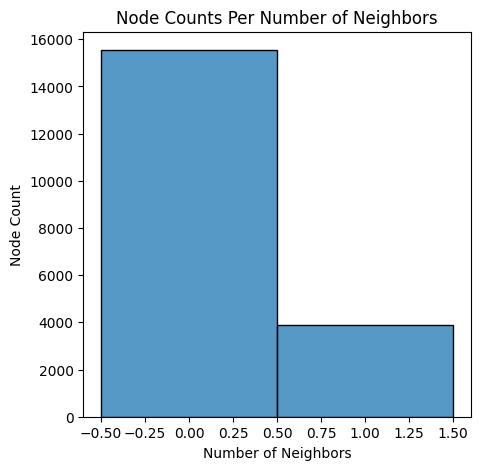

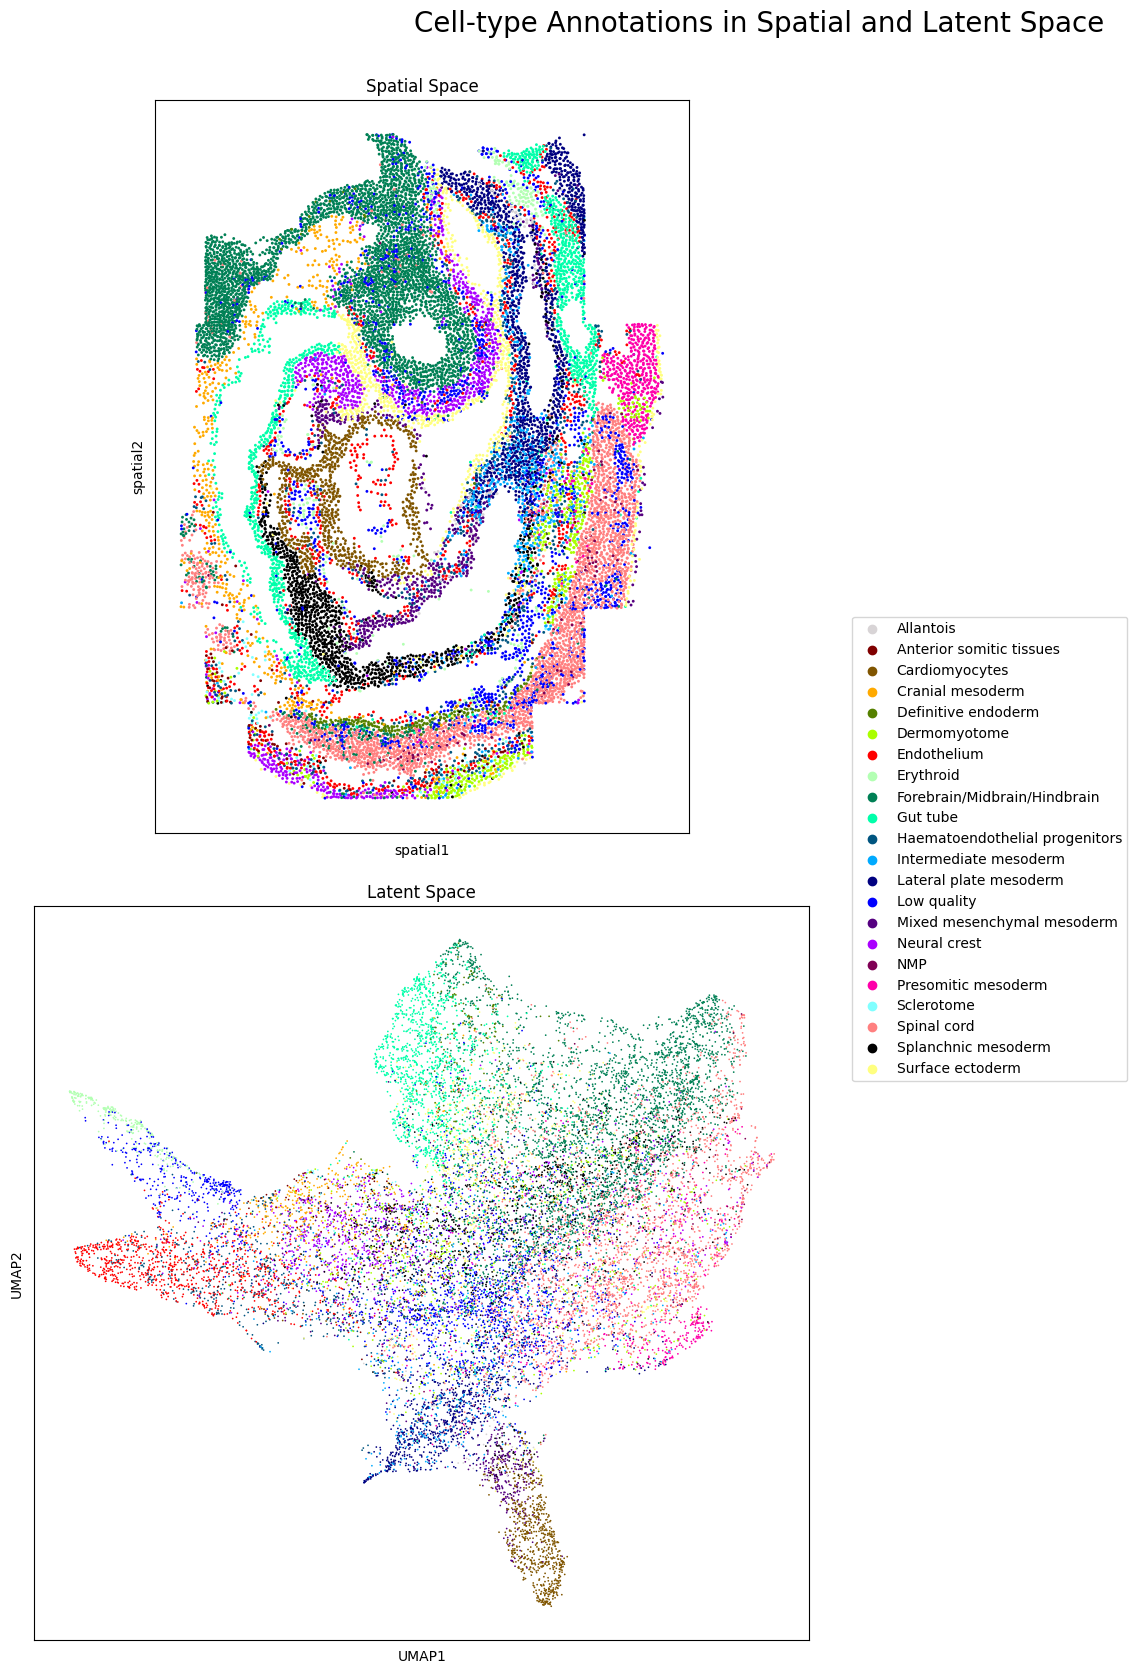

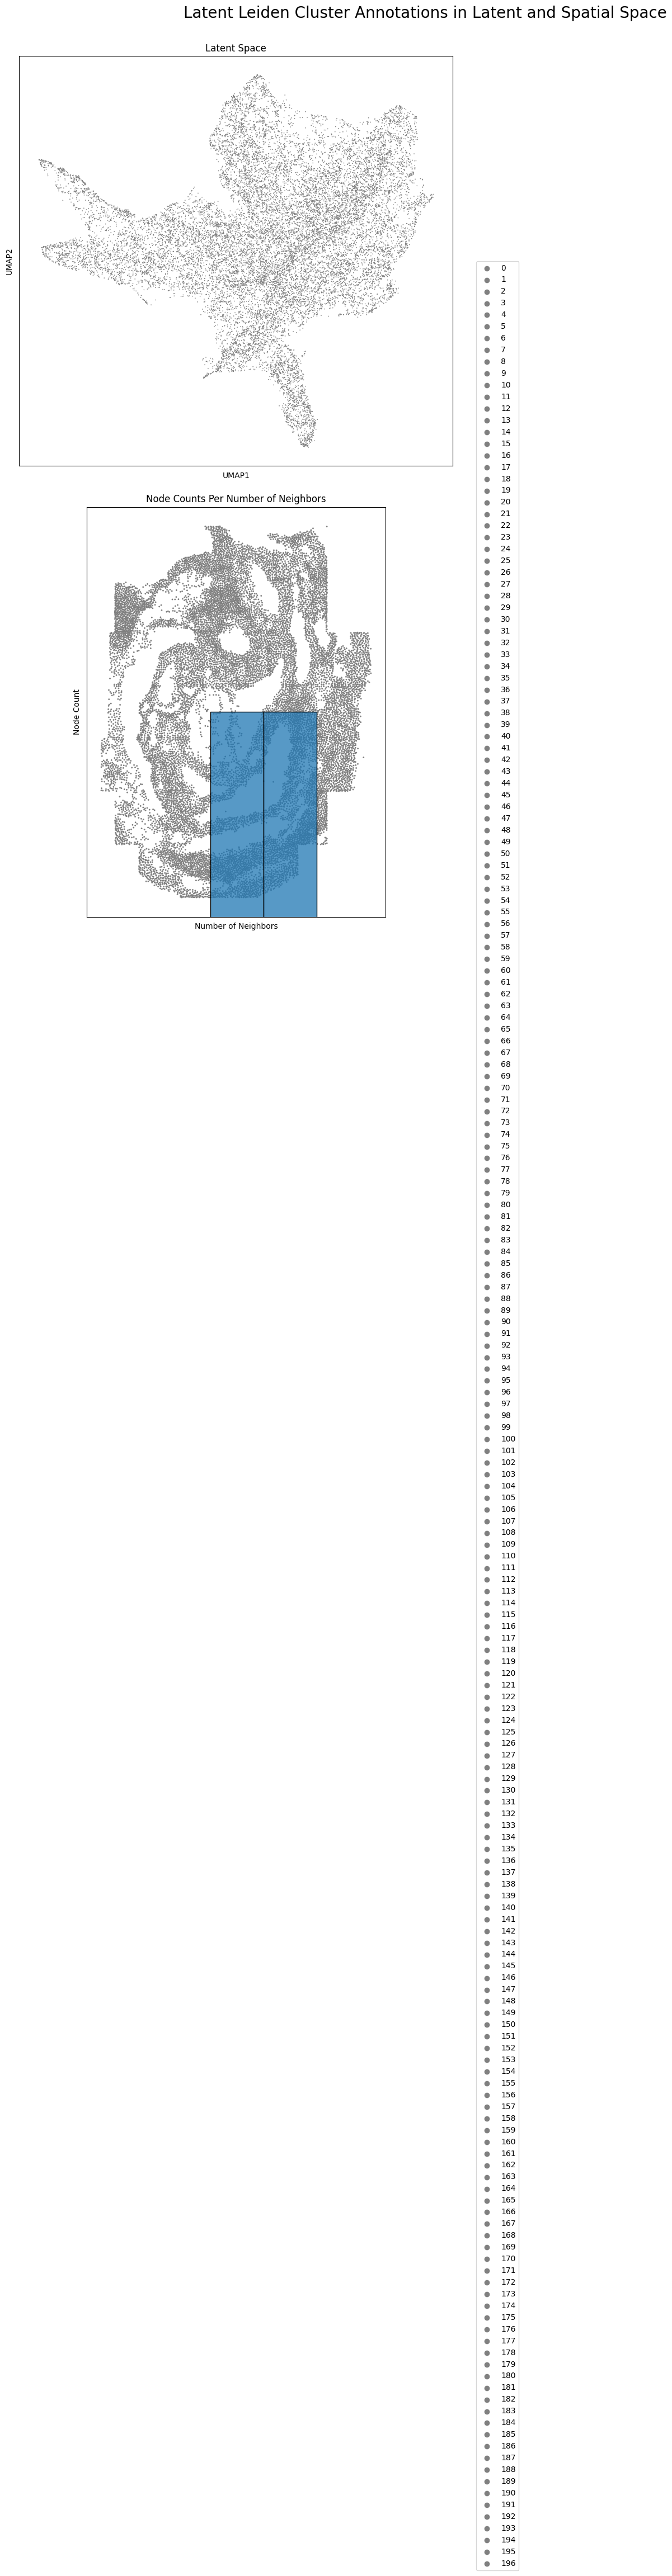

In [13]:
hyperparam_option_dict = {}
hyperparam_option_dict["n_neighs"] = [2, 4, 8, 16, 32, 64]
hyperparam_option_dict["radius"] = [0.01] #[0.05]
hyperparam_option_dict["include_edge_recon_loss"] = [True]
hyperparam_option_dict["include_gene_expr_recon_loss"] = [True]
hyperparam_option_dict["gene_expr_recon_dist"] = ["nb"]
hyperparam_option_dict["node_label_method"] = ["one-hop-norm"]
hyperparam_option_dict["active_gp_thresh_ratio"] = [0.]
hyperparam_option_dict["conv_layer_encoder"] = ["gcnconv"]
hyperparam_option_dict["encoder_n_attention_heads"] = [1]
hyperparam_option_dict["n_addon_gps"] = [0]
hyperparam_option_dict["n_epochs"] = [10]
hyperparam_option_dict["n_epochs_all_gps"] = [2]
hyperparam_option_dict["lr"] = [0.01]
hyperparam_option_dict["lambda_edge_recon"] = [1.]
hyperparam_option_dict["lambda_gene_expr_recon"] = [1.]
hyperparam_option_dict["lambda_group_lasso"] = [0]
hyperparam_option_dict["lambda_l1_addon"] = [0]

run_hyperparam_benchmarking(dataset=dataset,
                            hyperparam_option_dict=hyperparam_option_dict,
                            n_iters=3,
                            experiment_name="benchmark_n_neighs",
                            gp_mask="combined_priors",
                            save_model=False)

### 2.2. Benchmark Loss Weights

In [ ]:
hyperparam_option_dict = {}
hyperparam_option_dict["n_neighs"] = [8]
hyperparam_option_dict["include_edge_recon_loss"] = [True]
hyperparam_option_dict["include_gene_expr_recon_loss"] = [True]
hyperparam_option_dict["gene_expr_recon_dist"] = ["nb"]
hyperparam_option_dict["node_label_method"] = ["one-hop-norm"]
hyperparam_option_dict["active_gp_thresh_ratio"] = [0.]
hyperparam_option_dict["conv_layer_encoder"] = ["gcnconv"]
hyperparam_option_dict["encoder_n_attention_heads"] = [1]
hyperparam_option_dict["n_addon_gps"] = [0]
hyperparam_option_dict["n_epochs"] = [10]
hyperparam_option_dict["n_epochs_all_gps"] = [2]
hyperparam_option_dict["lr"] = [0.01]
hyperparam_option_dict["lambda_edge_recon"] = [0.1, 0.3, 1., 3.]
hyperparam_option_dict["lambda_gene_expr_recon"] = [0.1, 0.3, 1., 3.]
hyperparam_option_dict["lambda_group_lasso"] = [0]
hyperparam_option_dict["lambda_l1_addon"] = [0]

run_hyperparam_benchmarking(dataset=dataset,
                            hyperparam_option_dict=hyperparam_option_dict,
                            n_iters=5,
                            experiment_name="benchmark_n_neighs",
                            gp_mask="combined_priors",
                            save_model=False)

### 2.3. Benchmark Encoder & Decoder Architecture

### 2.4. Benchmark Loss Inclusions

### 2.5. Benchmark De-Novo GPs